In [2]:
import pandas as pd
import numpy as np

boxrec_data = pd.read_csv('boxrec_tables.csv')
df = pd.DataFrame(boxrec_data)

stance - missing = 82/793 - pct missing = 10.34%    
height - missing = 98/793 - pct missing = 12.36%    
reach - missing = 380/793 - pct missing = 47.92%    
birth place - missing = 79/793 - pct missing = 9.96%

age - missing = 19/793 - pct missing = 2.4%

In [3]:
df.replace(to_replace='None', value=np.nan, regex=True, inplace=True)

df.insert(3, 'div index', '')

div_list = ['heavy', 'cruiser', 'lightheavy', 'supermiddle', 'middle', 'superwelter', 'welter', 'superlight', 'light', 'feather', 'superbantam', 'bantam', 'superfly', 'fly', 'lightfly', 'minimum']

x = 0
for value in df['division']:
    df.at[x, 'div index'] = div_list.index(value)
    x += 1

In [4]:
ds = df.sort_values(by=['div index', 'division rating'], ascending=True)
# Can see age/height/reach need to be turned to float64s
cols_to_convert = ['age', 'height', 'reach']

for col in cols_to_convert:
    ds[col] = ds[col].astype(float)

In [5]:
dropped_missing_height_ds = ds.dropna(subset=['height'])
#Dropping missing height values gives 695 rows 
dropped_age_ds = dropped_missing_height_ds.dropna(subset=['age'])
#Dropping the missing age values from the new dataframe leaves 688 rows of data.
new_ds = dropped_age_ds

In [6]:
def replace_nan_with_mean(dataframe, column, grouping_column):
    dataframe[column] = dataframe.groupby(grouping_column)[column].transform(lambda x: x.fillna(round(x.mean(), 2)))

In [ ]:
diff_reach = new_ds.reach - new_ds.height
new_ds.insert(12, 'diff reach', diff_reach)

replace_nan_with_mean(new_ds, 'diff reach', 'division')

In [8]:
new_ds.reach.isnull().sum()

279

In [ ]:
new_list = new_ds.reach.isnull().index
reach_min = new_ds.reach.min()

for x in new_list:
    if new_ds.reach[x] >= reach_min:
        pass
    else:
        new_ds.reach[x] = new_ds.height[x] + new_ds['diff reach'][x]

In [10]:
import matplotlib.pyplot as plt

In [ ]:
new_ds.plot.scatter(x='height', y='reach', c='div index', colormap='viridis')

clear relationship between the division and the height/reach of a boxer - the heavier the division, the greater the fighter's length or reach. there are some obvious outliers in the data too.

In [ ]:
average_by_division = new_ds.groupby(['div index']).mean(numeric_only=True).round(2)
average_everything_numeric = new_ds.mean(numeric_only=True).round(2)

average_by_division

In [ ]:
plt.figure(figsize=(16, 8), dpi=120)

for x in average_by_division:
    plt.plot(average_by_division[x], label=x)

plt.title('Average of column values by Division')
plt.xlabel('div index - 0=heavyweight, 15=minimumweight')
plt.ylabel('Average value')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()

width = 16
height = 8
fig.set_size_inches(width, height)
ax.plot(average_by_division['height'], label='height')
ax.plot(average_by_division['KOs'], label='KOs')
ax.plot(average_by_division['rounds'], label='rounds')
ax.plot(average_by_division['reach'], label='reach')

ax2 = ax.twinx()
ax2.plot(average_by_division['age'], label='age', color='black')
ax2.set_ylabel('Age')
ax.legend()
ax.set_xticks(np.arange(0, 16, 1))
ax.set_title('Average of column values by Division')
ax.set_xlabel('div index - 0=heavyweight, 15=minimumweight')
ax.set_ylabel('Average value')

In [ ]:
new_ds['reach'].hist(bins=20, alpha=0.5, legend=True)
new_ds['height'].hist(bins=20, alpha=0.5, legend=True)

In [ ]:
new_ds['age'].hist(bins=20, legend=True)

In [12]:
#CLEANING REMAINING NULL VALUES
column_list = new_ds.columns

for x in column_list:
    if new_ds[x].isnull().sum() != 0:
        print(f'{x} null values: {new_ds[x].isnull().sum()}')
        # stance null values: 26
        # birth place null values: 28

stance_null = new_ds['stance'].isnull().index
birth_null = new_ds['birth place'].isnull().index
#7 birthplace nulls have no stance value, as there is no overlap and this isn't something that can be imputed, we are removing all nulls.

stance null values: 26
birth place null values: 28


In [13]:
# removing stance and birthplace null values... will first remove stance nulls as they are more important, and then remove birth place nulls.
dropping_stance_ds = new_ds.dropna(subset=['stance'])
clean_ds = dropping_stance_ds.dropna(subset=['birth place'])
# running null check
for x in column_list:
    if clean_ds[x].isnull().sum() != 0:
        print(f'{x} null values: {clean_ds[x].isnull().sum()}')

In [ ]:
from datetime import datetime

dates = clean_ds.debut.index
for x in dates:
    clean_ds.debut[x] = datetime.strptime(clean_ds.debut[x], '%d/%m/%Y').date()

clean_ds.debut = pd.to_datetime(clean_ds.debut)

In [ ]:
clean_ds.dtypes

In [15]:
end_date = pd.to_datetime('2022/12/06')
days_active = end_date - clean_ds.debut

In [16]:
clean_ds.insert(8, 'days active', days_active)

In [ ]:
#drop name + one hot encode 'stance'
preproc_ds = clean_ds

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#perform label encoding on 'team' column
preproc_ds.stance= label_encoder.fit_transform(preproc_ds.stance)


In [18]:
preproc_ds = preproc_ds.drop('name', axis=1)
preproc_ds = preproc_ds.drop('division', axis=1)
preproc_ds = preproc_ds.drop('diff reach', axis=1)
preproc_ds = preproc_ds.drop('residence', axis=1)
preproc_ds = preproc_ds.drop('birth place', axis=1)
preproc_ds = preproc_ds.drop('debut', axis=1)
preproc_ds['div index'] = preproc_ds['div index'].astype(int)

In [19]:
preproc_ds['days active'] = preproc_ds['days active'].astype(str)
preproc_ds['days active'] = preproc_ds['days active'].map(lambda x: x.rstrip(' days'))
preproc_ds['days active'] = preproc_ds['days active'].astype(int)

In [160]:
preproc_ds.dtypes

division rating      int64
div index            int32
bouts                int64
rounds               int64
KOs                float64
days active          int32
age                float64
stance               int32
height             float64
reach              float64
wins                 int64
losses               int64
draws                int64
KO wins              int64
KO losses            int64
dtype: object

In [203]:
six_ds = preproc_ds[['height', 'reach', 'age', 'days active', 'div index', 'division rating']]


0: [0.577, 0.627, 0.62, 0.648, 0.647, 0.65, 0.623, 0.637, 0.636]
1: [0.689, 0.713, 0.638, 0.616, 0.592, 0.56, 0.543, 0.517, 0.521]
2: [0.607, 0.522, 0.578, 0.6, 0.615, 0.627, 0.62, 0.628, 0.601]
3: [0.62, 0.573, 0.592, 0.626, 0.638, 0.657, 0.633, 0.583, 0.596]
4: [0.541, 0.581, 0.545, 0.602, 0.6, 0.582, 0.62, 0.61, 0.584]
5: [0.618, 0.651, 0.612, 0.618, 0.587, 0.625, 0.633, 0.642, 0.658]
6: [0.622, 0.557, 0.554, 0.56, 0.55, 0.553, 0.534, 0.529, 0.507]
7: [0.558, 0.563, 0.493, 0.551, 0.544, 0.559, 0.561, 0.549, 0.533]
8: [0.651, 0.671, 0.661, 0.635, 0.644, 0.596, 0.585, 0.598, 0.578]
9: [0.558, 0.577, 0.542, 0.561, 0.556, 0.586, 0.561, 0.561, 0.568]
10: [0.627, 0.671, 0.626, 0.651, 0.676, 0.663, 0.708, 0.706, 0.675]
11: [0.566, 0.606, 0.57, 0.577, 0.59, 0.632, 0.58, 0.606, 0.606]
12: [0.705, 0.676, 0.657, 0.658, 0.644, 0.61, 0.625, 0.626, 0.595]
13: [0.545, 0.561, 0.538, 0.591, 0.586, 0.562, 0.557, 0.579, 0.553]
14: [0.708, 0.56, 0.577, 0.58, 0.584, 0.621, 0.564, 0.54, 0.539]
15: [0.496

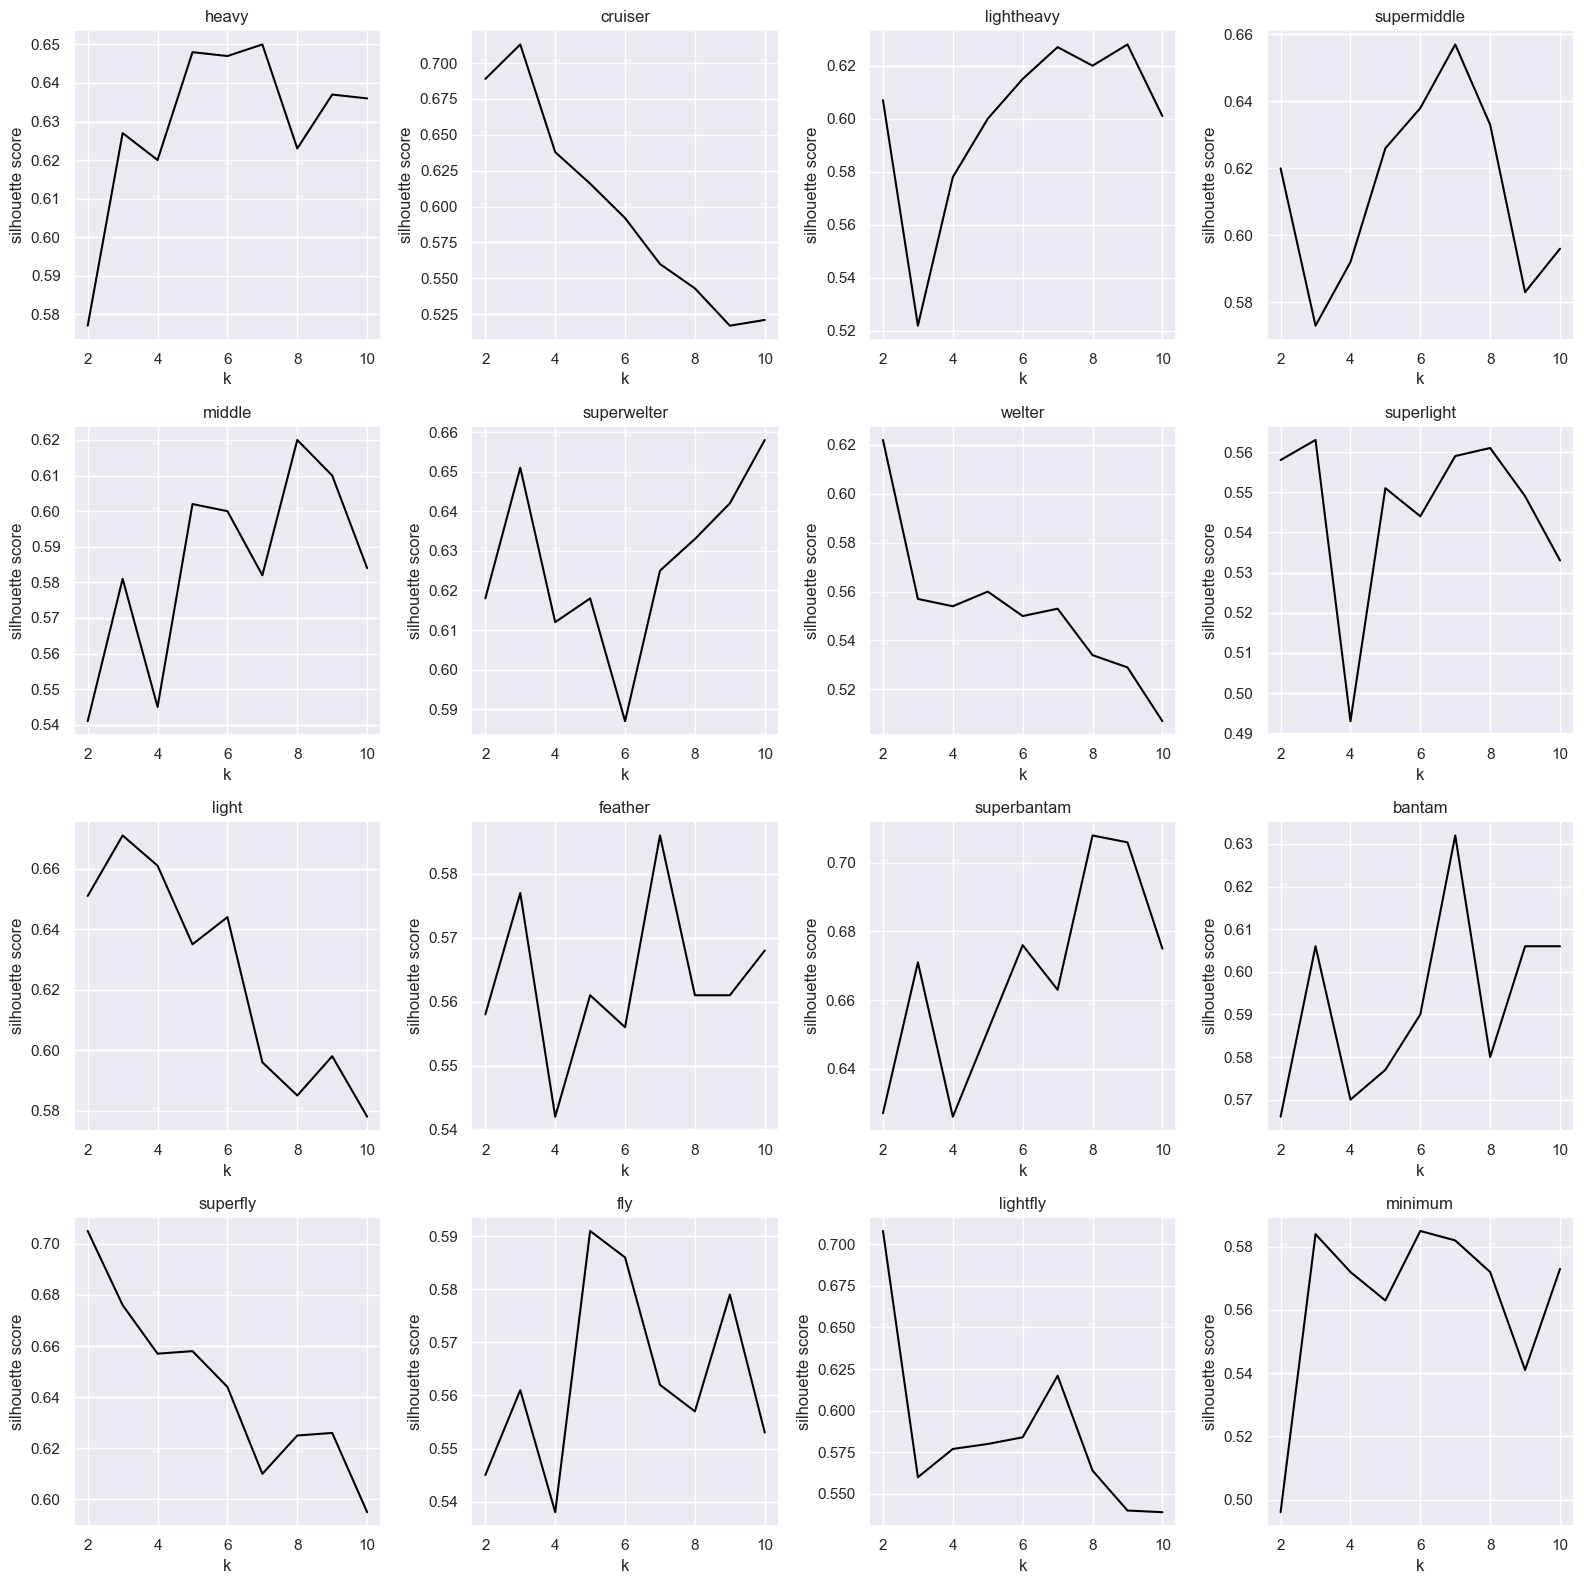

In [221]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Group the six_ds DataFrame by the div index column
grouped_df = six_ds.groupby('div index')

# Use the apply method to apply the k-means clustering algorithm to each group
grouped_df_clustered = grouped_df.apply(lambda group: KMeans(n_clusters=k).fit_predict(group))

# Create a figure with 16 subplots (one for each div index value)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Use a for loop to plot each group in a separate subplot
# Use a for loop to plot each group in a separate subplot
for i, (name, group) in enumerate(grouped_df):
    # Create an empty list to store the silhouette scores for this group
    silhouette_scores = []

    # Use a nested for loop to iterate over the range of k values from 2 to 8
    for k in range(2, 11):
        # Create a KMeans object
        model = KMeans(n_clusters=k)

        # Fit the model to the data in this group
        cluster_labels = model.fit_predict(group)

        # Calculate the silhouette score for this model
        score = silhouette_score(group, cluster_labels)

        # Append the silhouette score to the list
        silhouette_scores.append(round(score, 3))
    print(f'{name}: {silhouette_scores}')

    # Use the plot method to plot the silhouette scores for this group
    axes[i // 4, i % 4].plot(range(2, 11), silhouette_scores, c='black')

    # Add x and y labels and a title to the subplot
    axes[i // 4, i % 4].set_xlabel('k')
    axes[i // 4, i % 4].set_ylabel('silhouette score')
    axes[i // 4, i % 4].set_title(f'{div_list[name]}')

# Adjust the spacing between the subplots
fig.tight_layout()

In [222]:
k = 6

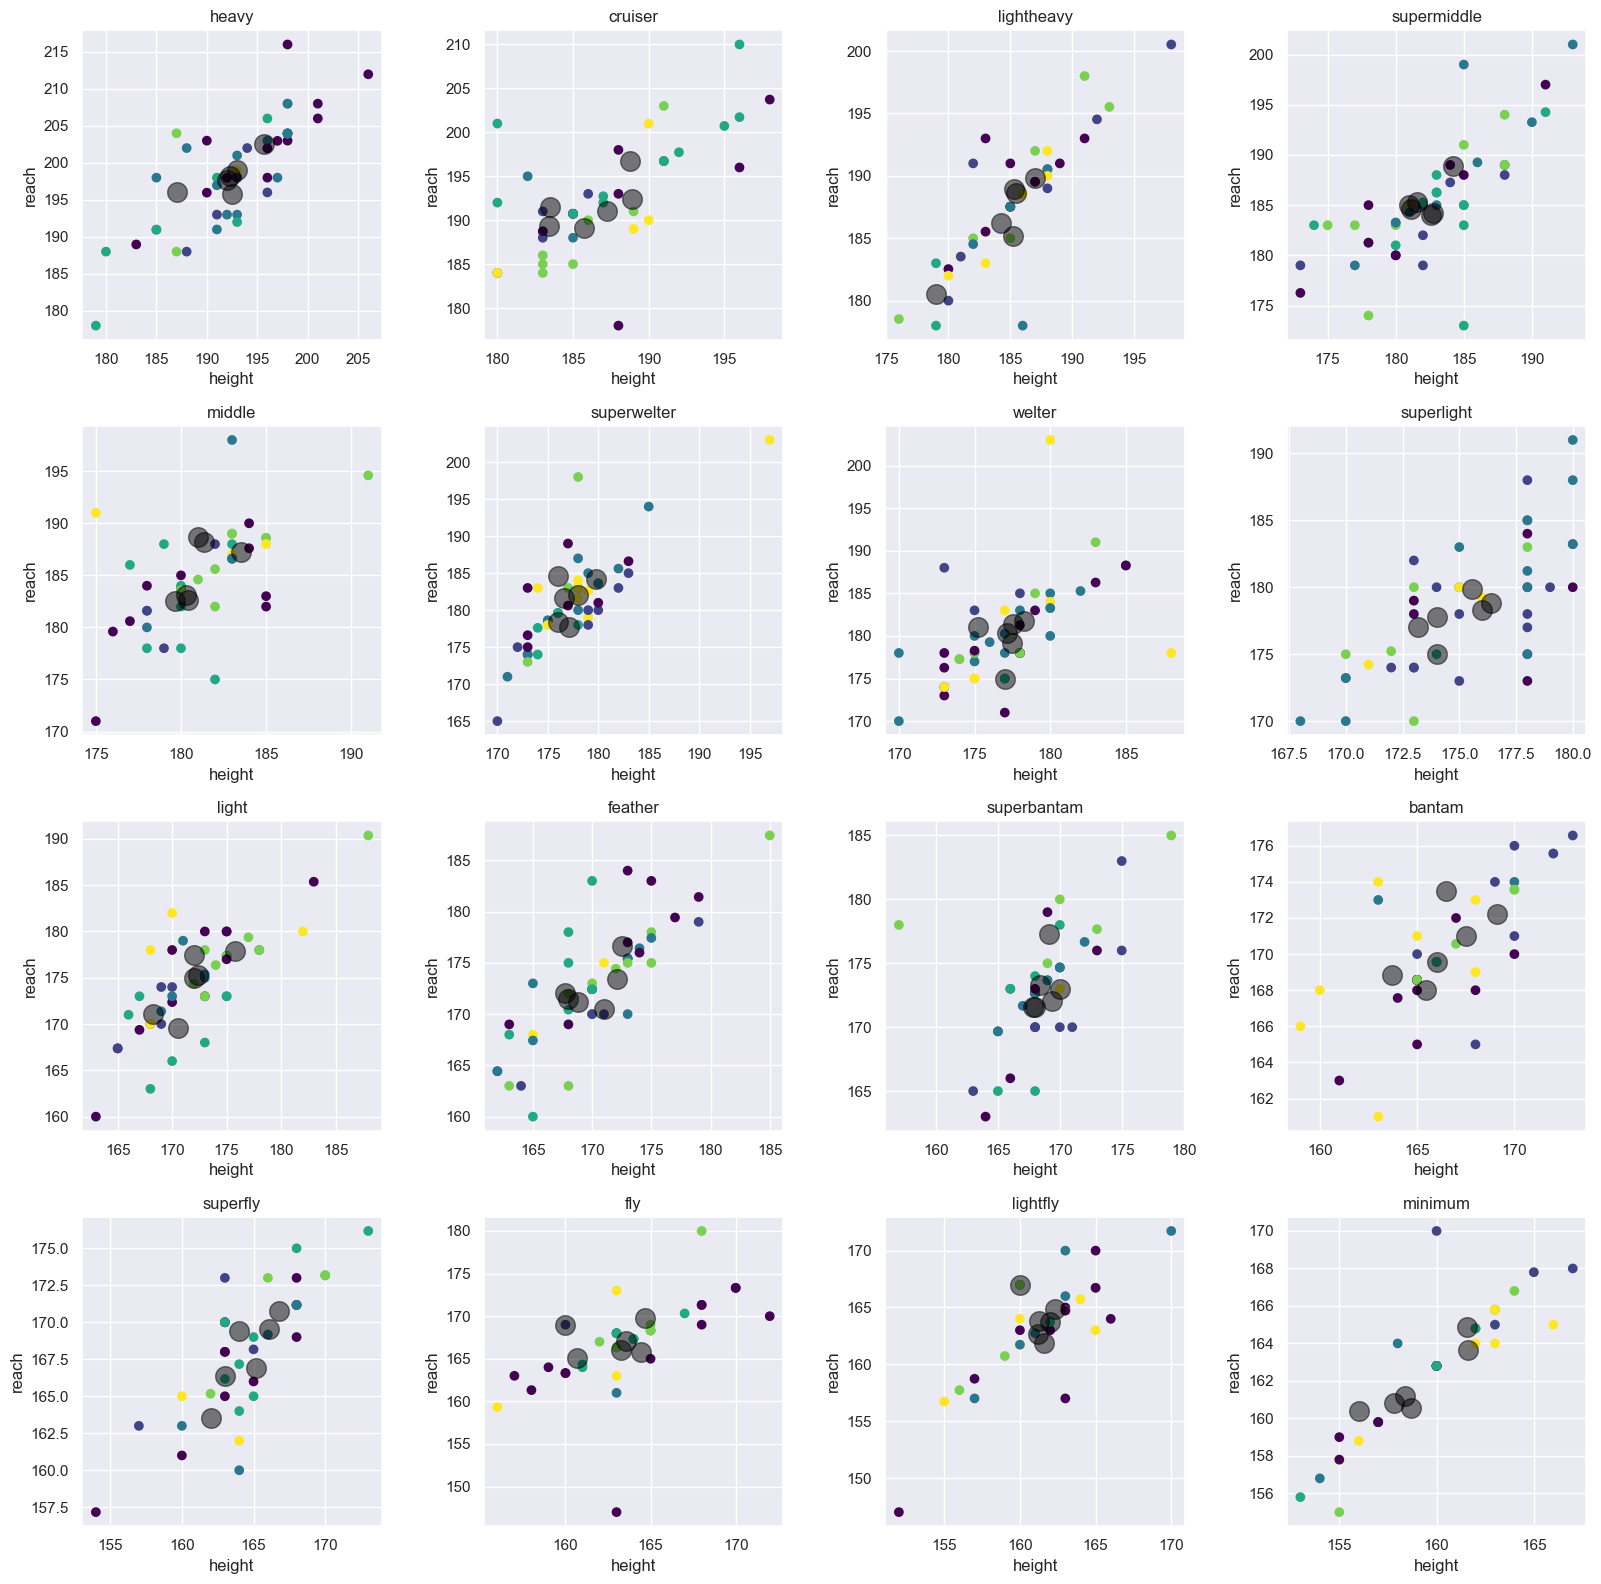

In [223]:
grouped_df = six_ds.groupby('div index')

# Create a figure with 16 subplots (one for each div index value)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Use a for loop to plot each group in a separate subplot
for i, (name, group) in enumerate(grouped_df):
    # Create a KMeans object
    model = KMeans(n_clusters=k)
    
    # Fit the model to the data in this group
    cluster_labels = model.fit_predict(group)
    
    # Use the scatter method to plot the data points
    axes[i // 4, i % 4].scatter(group['height'], group['reach'], c=cluster_labels, cmap='viridis')

    # Use the scatter method again to plot the cluster centers
    cluster_centers = model.cluster_centers_
    axes[i // 4, i % 4].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, alpha=0.5)
    
    # Add x and y labels and a title to the subplot
    axes[i // 4, i % 4].set_xlabel('height')
    axes[i // 4, i % 4].set_ylabel('reach')
    axes[i // 4, i % 4].set_title(f'{div_list[name]}')

# Adjust the spacing between the subplots
fig.tight_layout()

from the K means clustering visualisations we can see an interesting 

In [224]:
grouped_df['height', 'age'].describe()

C:\Users\smbal\AppData\Local\Temp\ipykernel_31032\2799942490.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df['height', 'age'].describe()


height                                                            \
           count        mean       std    min     25%    50%    75%    max   
div index                                                                    
0           47.0  193.042553  5.563692  179.0  190.50  193.0  197.5  206.0   
1           39.0  187.128205  4.878414  180.0  183.00  186.0  190.5  198.0   
2           39.0  185.153846  4.386213  176.0  182.00  185.0  188.0  198.0   
3           44.0  182.477273  4.790925  173.0  180.00  182.5  185.0  193.0   
4           40.0  181.200000  3.298795  175.0  178.75  182.0  183.0  191.0   
5           46.0  177.652174  4.483141  170.0  174.25  178.0  180.0  197.0   
6           45.0  177.244444  3.862145  170.0  175.00  177.0  180.0  188.0   
7           43.0  175.325581  3.350344  168.0  173.00  175.0  178.0  180.0   
8           43.0  172.162791  4.947006  163.0  169.00  172.0  175.0  188.0   
9           42.0  170.357143  5.078993  162.0  168.00  170.0  173.0  185.0   
10          40.0  168.600000  3.628943  157.0  167.75  168.0  170.0  179.0   
11          37.0  166.432432  3.287523  159.0  165.00  166.0  169.0  173.0   
12          36.0  164.722222  3.776704  154.0  163.00  164.5  168.0  173.0   
13          34.0  163.705882  3.745943  156.0  161.25  163.0  165.0  172.0   
14          31.0  161.548387  3.613297  152.0  160.00  163.0  163.0  170.0   
15          33.0  159.818182  3.778678  153.0  157.00  160.0  163.0  167.0   

            age                                                       
          count       mean       std   min    25%   50%    75%   max  
div index                                                             
0          47.0  33.212766  4.713238  23.0  30.00  33.0  35.50  43.0  
1          39.0  32.717949  4.701336  24.0  30.00  32.0  34.50  52.0  
2          39.0  31.512821  3.331443  24.0  29.50  31.0  33.00  39.0  
3          44.0  30.386364  4.779880  21.0  27.00  30.0  33.25  43.0  
4          40.0  30.675000  4.626498  23.0  27.75  30.0  33.00  43.0  
5          46.0  30.434783  4.047782  21.0  27.00  31.0  33.75  37.0  
6          45.0  30.800000  3.876503  23.0  28.00  31.0  34.00  38.0  
7          43.0  29.813953  3.762318  23.0  27.00  30.0  33.00  39.0  
8          43.0  30.000000  4.795832  23.0  27.00  29.0  33.00  46.0  
9          42.0  27.976190  3.828571  21.0  25.00  28.0  30.75  38.0  
10         40.0  28.925000  4.346454  22.0  26.00  28.0  32.00  43.0  
11         37.0  29.243243  4.374201  22.0  26.00  29.0  31.00  42.0  
12         36.0  30.138889  4.715644  22.0  26.75  30.5  34.00  40.0  
13         34.0  28.352941  4.457764  23.0  25.00  27.0  31.50  40.0  
14         31.0  27.677419  4.407472  20.0  25.50  27.0  29.50  42.0  
15         33.0  26.787879  4.083179  20.0  24.00  26.0  28.00  37.0

In [225]:
for name, group in grouped_df:
    height_q1 = group['height'].quantile(0.25)
    height_q3 = group['height'].quantile(0.75)
    age_q1 = group['age'].quantile(0.25)
    age_q3 = group['age'].quantile(0.75)

    height_IQR = height_q3 - height_q1
    age_IQR = age_q3 - age_q1

    height_outliers = group[( (group['height'] < (height_q1 - 1.5*height_IQR)) | (group['height'] > (height_q3 + 1.5*height_IQR)) )]
    age_outliers = group[( (group['age'] < (age_q1 - 1.5*age_IQR)) | (group['age'] > (age_q3 + 1.5*age_IQR)) )]
  
    # Count the number of outliers in the 'height' and 'age' columns
    height_outlier_count = height_outliers.count()
    age_outlier_count = age_outliers.count()
    
    print(f'{div_list[name]}: height outliers: {height_outlier_count.height} - age outliers: {age_outlier_count.age}')

heavy: height outliers: 1 - age outliers: 0
cruiser: height outliers: 0 - age outliers: 1
lightheavy: height outliers: 1 - age outliers: 3
supermiddle: height outliers: 1 - age outliers: 1
middle: height outliers: 1 - age outliers: 1
superwelter: height outliers: 1 - age outliers: 0
welter: height outliers: 1 - age outliers: 0
superlight: height outliers: 0 - age outliers: 0
light: height outliers: 1 - age outliers: 1
feather: height outliers: 1 - age outliers: 0
superbantam: height outliers: 6 - age outliers: 1
bantam: height outliers: 0 - age outliers: 3
superfly: height outliers: 1 - age outliers: 0
fly: height outliers: 1 - age outliers: 0
lightfly: height outliers: 3 - age outliers: 1
minimum: height outliers: 0 - age outliers: 2
